# Artificial Neural Network implementation using PyTorch

### Overview
- Multi-class classification problem
- Structure: 
    - input -> hidden layers -> output (one-hot encoded: i.e. one bucket per class) -> softmax to get probabilites for classes -> choose class with highest probability
    - Note: for binary classification, we would use sigmoid activation at the end rather than softmax.

Import packages here

In [65]:
# Numpy
import numpy as np
import time
import matplotlib.pyplot as plt
# Import torch core functionalities
import torch
# torch neural network library
import torch.nn as nn
# Activation functions
import torch.nn.functional as F
# Optimizer to do gradient descent
import torch.optim as optim
# For stuff like data 
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

### Step 1: Get some data
Let's use the MNIST dataset, which is included in the torchvision.datasets module. The goal of the MNIST dataset is classification: identify given an image of a handwritten number, which number a sample is.

In [66]:
# downloads a local copy of the mnist data set: raw images
mnist_data = torchvision.datasets.MNIST('data', train=True, download=True)
# Put the images in list format: the items in the list are a tuple of (pillow image objects, identified digit label)
    # ex: (address for pillow image, 5), meaning that the digit is hand identified as 5
mnist_data = list(mnist_data)

Split the data we have into training and validation

In [67]:
# Separate 1000 images for training, 1000 images for validation
mnist_train = mnist_data[:1000]
mnist_val   = mnist_data[1000:2000]
# img_to_tensor is initialized as a method that converts an image to a tensor
img_to_tensor = torchvision.transforms.ToTensor()

print(mnist_train[0])
# One datapoint of the image tensor
print(img_to_tensor(mnist_train[0][0]).shape)


(<PIL.Image.Image image mode=L size=28x28 at 0x1CD285B1B70>, 5)
torch.Size([1, 28, 28])


### Step 2: Build the neural network model

In the chosen dataset, the 28x28 pixel pictures can be converted to a tensor that have dimensions 1x28x28 (see above, the dim 0 = 1 field is not really relevant), 
so we need an input layer of 28 * 28 = 784 units. <br>

Since there are 10 classes to guess from, which are the numbers 0 - 9, we need 10 outputs in the output layer: the NN will output numbers to these 10 outputs, and the index with the highest value in the <br> tensor will be the prediction of the class. <br>

The number of hidden layers and number of neurons/units in each layer are hyperparameters: For this implementation, we will go with two additional layers. <br>

Input layer: 28*28 pixels = 784 pixels of info <br>
Hidden layer 1: some number of hidden units $n_{1}$ <br>
Hidden layer 2: some number of hidden units $n_{2}$ <br>
Output: a 1x10 tensor that gives "probability" that the image belongs to a class (a number from 0-9): prediction is the highest probability
- we need to apply softmax to this tensor to give the actual probabilities in range [0,1]: but in theory this is not needed. For Binary classification: we use sigmoid instead
- WE DO NOT APPLY SOFTMAX IN THE NN CLASS: the loss function expects logits (i.e. outputs of linear layers without any activation applied to them)

All layers are fully connected in this linear method

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, in_features=28*28, n1=8, n2=9, out_features=10):
        # necessary step to initialize an object in its own class
        super().__init__()
        # Can program two linear, fully connected layers in using the nn.Linear method:
        self.layer1 = nn.Linear(in_features, n1)
        self.layer2 = nn.Linear(n1, n2)
        self.out = nn.Linear(n2, out_features)
    def forward(self, x):
        # NOTE: x is a 1x784 TENSOR object
        # activation function 1: RELU
        x = F.relu(self.layer1(x))
        # activation function 2: using RELU
        x = F.relu(self.layer2(x))
        # Output layer: DONT APPLY SOFTMAX HERE
        y = self.out(x)

        return y
    

### Step 3: Train

Choose Hyperparameters:

In [69]:
# layer size 1
n1 = 50
# layer size 2
n2 = 50
# learning rate
learning_rate = 0.01
# epochs: one run through all the data
epochs = 1000
# momentum term for stochastic gradient descent
SGD_momentum = 0.9

Instansiate an instance of the model class:

In [70]:
# sets a manual seed for randomization
torch.manual_seed(1)
# Create an instance of our model
model = Model(28*28, n1, n2, 10)
model.parameters

<bound method Module.parameters of Model(
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=50, bias=True)
  (out): Linear(in_features=50, out_features=10, bias=True)
)>

Set criterion of the model too measure error: aka the type of Loss function, and an optimizer to do the gradient descent
Design:
- using a cross entropy loss criterion: <br>
$ H(p, q) = -\sum_{x \epsilon classes} p(x)log q(x) $
- using stochastic Gradient Descent with momentum as the weight update: <br> 
$v_{ji}^t = \lambda v_{ji}^{t-1} - \gamma\frac{\partial E}{\partial w_{ji}}$ <br>
$w_{ji}^{t+1} = w_{ji}^{t} + v_{ji}^{t}$
- where:
    - $p(x)$ is the true distribution, i.e. the true label of the input 
    - $q(x)$ is the predicted distribution, i.e. the predicted label of the input 
    - $w_{ji}$ is the $j^{th}$ component of the weight vector at some step $i$ in $y = w^Tx$
    - $E$ is the error/loss function (i.e. the cross-entropy loss equation)
    - $v_{ji}$ is the intermediate SGD term for each weight component
    - $\gamma$ is the learning rate
    - $\lambda$ is the momentum term (from 0 to 1)


In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=SGD_momentum)

Prep the data: collect training data in X: a tensor where each item is a 1 x 784 block of pixel info

In [72]:
X = []
y = []

for (image, label) in mnist_train:
    # we assume image is still in image format. above we imported img_to_tensor to convert the image to a tensor:
    img_tensor = img_to_tensor(image)
    # since img_tensor is a 28*28 image, we need to flatten it to a 1x784 vector:
    # -1 means that the dimension is inferred: since we are using all the 784 elements in the tensor, 
    # Pytorch infers the dimension as one: since there's nothing else to store
    flattened = img_tensor.view(-1, 28*28)
    X.append(flattened)
    y.append(label)

X_train = torch.cat(X, dim = 0)
y_train = torch.LongTensor(y)

print(X_train.shape)
print(y_train.shape)


torch.Size([1000, 784])
torch.Size([1000])


Now we do the training with these training samples:

In [73]:
# y_pred = model.forward(X_train)
# print(y_pred[999])
# loss = criterion(y_pred, y_train)
# print(loss)

losses = []
accuracies = []

for i in range(epochs):
    # get prediction from model given data
    y_pred = model.forward(X_train)

    # Measure loss/error
    loss = criterion(y_pred, y_train)

    # Keep track of the losses:
    losses.append(loss.detach().numpy()) # detatch turns the tensor quantity into a numpy quantity so we can graph the losses

    # Keep track of accuracy:
    # Can apply softmax here:
    prob = F.softmax(y_pred, dim=1) 
    correct_guesses = 0
    # this will get us the index with the highest value in the 1x10 y_pred, which will give us the actual predictions
    actual_guesses = torch.argmax(prob, dim=1)
    for j, guess in enumerate(actual_guesses):
        if guess == y_train[j]:
            correct_guesses += 1
    accuracies.append(correct_guesses * 100 / len(y_pred))

    # Print losses every 10 epochs
    if i % 10 == 0:
        print(f'Epoch: {i} and loss: {loss}')

    # Do back-propagation to adjust the weights: 
    # take error rate of the forward propagation and do some gradient descent algorithm (our case: SGD). Very east to do using torch:

    # Computes the back-propagation for each parameter:
    loss.backward()
    # Applies the update for each parameter
    optimizer.step()
    # Cleanup step for Pytorch
    optimizer.zero_grad()

Epoch: 0 and loss: 2.2991480827331543
Epoch: 10 and loss: 2.2864186763763428
Epoch: 20 and loss: 2.2609505653381348
Epoch: 30 and loss: 2.223745584487915
Epoch: 40 and loss: 2.1692094802856445
Epoch: 50 and loss: 2.0873661041259766
Epoch: 60 and loss: 1.9636123180389404
Epoch: 70 and loss: 1.7852050065994263
Epoch: 80 and loss: 1.5526725053787231
Epoch: 90 and loss: 1.3017765283584595
Epoch: 100 and loss: 1.0793218612670898
Epoch: 110 and loss: 0.9053601622581482
Epoch: 120 and loss: 0.7750953435897827
Epoch: 130 and loss: 0.6771579384803772
Epoch: 140 and loss: 0.6019294261932373
Epoch: 150 and loss: 0.5426348447799683
Epoch: 160 and loss: 0.4947145879268646
Epoch: 170 and loss: 0.4551957845687866
Epoch: 180 and loss: 0.42189550399780273
Epoch: 190 and loss: 0.39330434799194336
Epoch: 200 and loss: 0.36842185258865356
Epoch: 210 and loss: 0.34646713733673096
Epoch: 220 and loss: 0.326918363571167
Epoch: 230 and loss: 0.30935201048851013
Epoch: 240 and loss: 0.2934122681617737
Epoch: 2

### Step 4: Tweak hyperparameters

Plotting the loss to visualize our machine learning process:

Text(0.5, 0, 'Epoch Number')

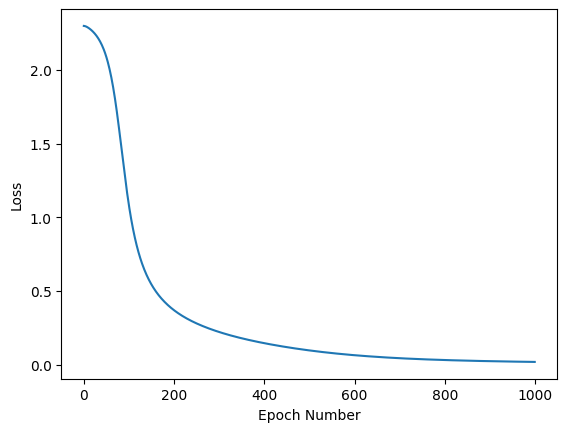

In [74]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoch Number")

Visualizing Accuracies:

Final Accuracy of the model: 100.0%


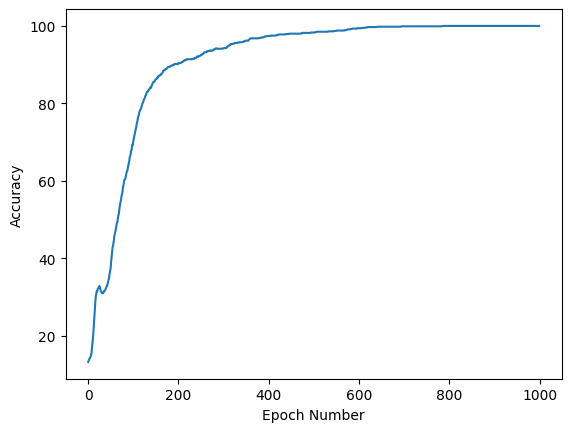

In [75]:
plt.plot(range(len(accuracies)), accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Epoch Number")

print(f"Final Accuracy of the model: {accuracies[-1]}%")

### Step 5: Test on the Validation set with the model done

i.e.: make predictions without updating the weights (i.e. doing any backpropagation)

In [76]:
# Prep the test data the same as before
X_temp = []
y_temp = []

for (image, label) in mnist_train:
    # we assume image is still in image format. above we imported img_to_tensor to convert the image to a tensor:
    img_tensor = img_to_tensor(image)
    # since img_tensor is a 28*28 image, we need to flatten it to a 1x784 vector:
    # -1 means that the dimension is inferred: since we are using all the 784 elements in the tensor, 
    # Pytorch infers the dimension as one: since there's nothing else to store
    flattened = img_tensor.view(-1, 28*28)
    X_temp.append(flattened)
    y_temp.append(label)

X_test = torch.cat(X_temp, dim = 0)
y_test = torch.LongTensor(y_temp)

# keep correct guesses here 
correct_guesses_test = 0
# TURN OFF BACK PROPAGATION USING torch.no_grad():
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)
    # DID NOT apply softmax here, can see that it doesn't matter
    actual_guesses_test = torch.argmax(y_eval, dim=1)
    for j, guess in enumerate(actual_guesses_test):
        if guess == y_test[j]:
            correct_guesses_test += 1

print(f"loss: {loss},  accuracy: {correct_guesses_test * 100 / len(y_eval)}")

loss: 0.017675215378403664,  accuracy: 100.0


### Conclusions from training

- smaller learning rate is better
- more layers are better
- more units per layer are better
- for SGD: higher momentum is better
- more epochs are better
- activation functions need to be carefully chosen: however for this case, RelU seemed to work fine for both layers

Obviously increasing accuracy comes with the tradeoff of making the model slower, so one should be careful in choosing hyperparameters that max out CPU/GPU usage in a given time frame needed.
While these are obvious conclusions, it's nice to have them here.

- Also:
    - Softmax doesn't actually change the result if you take the argmax of the tensor: It will return the same result
